# Loading LSTM from training notebook

In [24]:
import torch
import pickle

import sys
sys.path.append('../')  # Go up to src/ directory
from models import LSTM_model

model = LSTM_model()
model.load_state_dict(torch.load('lstm_model.pth'))
scaler_X, scaler_y = pickle.load(open('scalers.pkl', 'rb'))

# Evaluate and plot

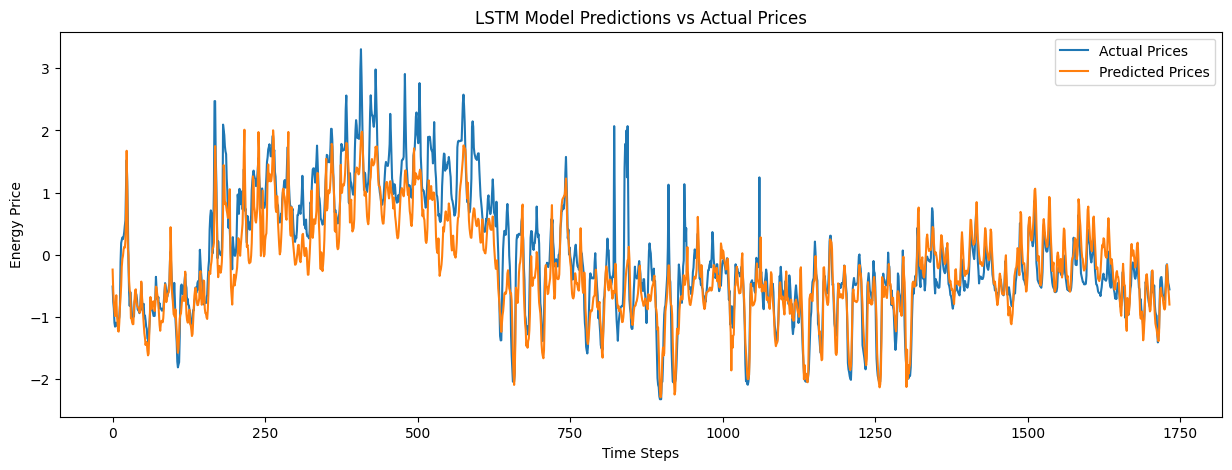

In [37]:
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

from dataset import EnergyPriceDataset, load_and_preprocess_energy_data

df = load_and_preprocess_energy_data('../../data/energy_data.csv')

feature_cols = ['Hour', 'day_nr', 'week_nr', 'year', 'wind_forecast_dah_mw', 'consumption_forecast_dah_mw', 'temp_forecast_dah_celcius', 'temp_norm_celcius', 'spot_lag1']
target_col = 'spot'

split_idx = int(len(df) * 0.8)
train_df = df[:split_idx]
test_df = df[split_idx:]

test_features = scaler_X.transform(test_df[feature_cols])
test_targets = scaler_y.transform(test_df[[target_col]])

sequence_length = 24 # 24 = one day, 168 = one week
test_dataset = EnergyPriceDataset(test_features, test_targets, sequence_length)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        pred = model(X_batch)
        predictions.extend(pred.squeeze().tolist())
        actuals.extend(y_batch.tolist())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(actuals, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.title('LSTM Model Predictions vs Actual Prices')
plt.xlabel('Time Steps')
plt.ylabel('Energy Price')
plt.show()

## OGD on the output

In [35]:
from OGD import OGD_Predictor

predictions_unscaled = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

ogd = OGD_Predictor(alpha=0.1, eta=0.5, q_init=10)

for t in range(len(predictions_unscaled)):
    y_pred = predictions_unscaled[t]
    y_true = actuals_unscaled[t]
    
    lower, upper = ogd.get_interval(y_pred)
    covered = ogd.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * ogd.q
        threshold = ogd.q
        
    if t % 100 == 0:
        lower, upper = ogd.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={ogd.q:.2f}")

print("\n ")
print(f"Coverage Rate: {ogd.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {ogd.q:.2f}")
print(f"Average Width: {np.mean(ogd.threshold_history)*2:.2f}")

misses = sum(1 for c in ogd.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(ogd.coverage_history)}")

t=0: [158.49, 179.39], pred=168.94, true=143.37, covered=False, q=10.45
t=100: [79.52, 123.42], pred=101.47, true=120.30, covered=True, q=21.95
t=200: [104.09, 185.99], pred=145.04, true=189.85, covered=False, q=40.95
t=300: [124.19, 229.09], pred=176.64, true=218.50, covered=True, q=52.45
t=400: [258.89, 386.79], pred=322.84, true=386.37, covered=True, q=63.95
t=500: [239.25, 378.15], pred=308.70, true=369.32, covered=True, q=69.45
t=600: [156.61, 329.51], pred=243.06, true=344.11, covered=False, q=86.45
t=700: [23.56, 198.46], pred=111.01, true=166.65, covered=True, q=87.45
t=800: [1.04, 165.94], pred=83.49, true=55.45, covered=True, q=82.45
t=900: [-76.99, 87.91], pred=5.46, true=-1.68, covered=True, q=82.45
t=1000: [118.10, 278.00], pred=198.05, true=181.26, covered=True, q=79.95
t=1100: [32.55, 184.45], pred=108.50, true=124.52, covered=True, q=75.95
t=1200: [103.04, 245.94], pred=174.49, true=167.05, covered=True, q=71.45
t=1300: [-22.23, 110.67], pred=44.22, true=32.58, covered=